In [1]:
%load_ext autoreload
%autoreload 2

from notebooks.utils import *

Training samples: 2000, Testing samples: 300


Epoch 10/10: 100%|██████████| 62/62 [00:00<00:00, 243.36it/s, acc=96.77%, loss=0.145] 


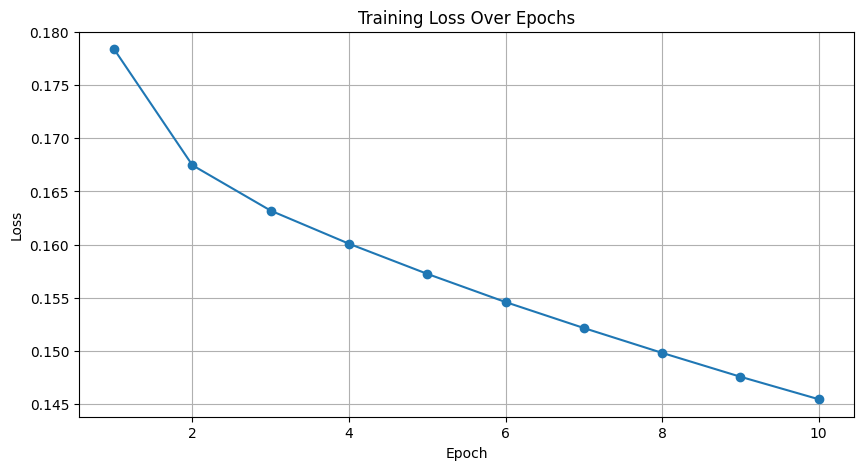

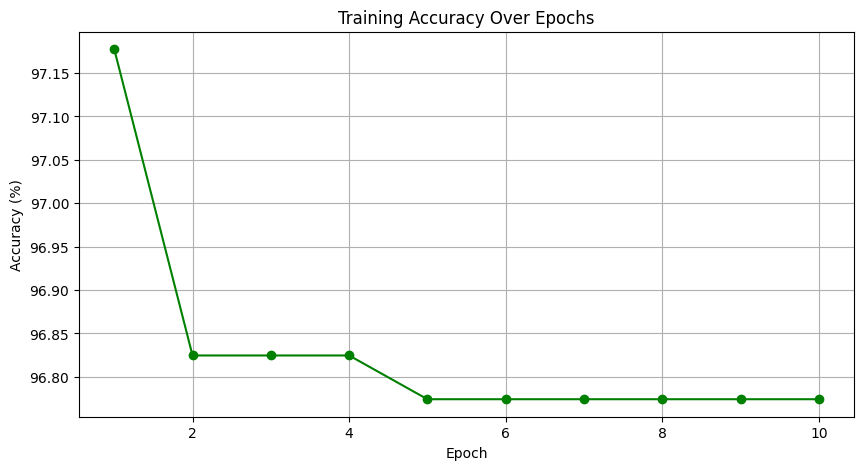

/fs01/home/minht/projects/diversified_prototypical_ensemble/notebooks/utils.py:229: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(prototypes[:, 0], prototypes[:, 1], c=['#e28743', '#1e81b0'],


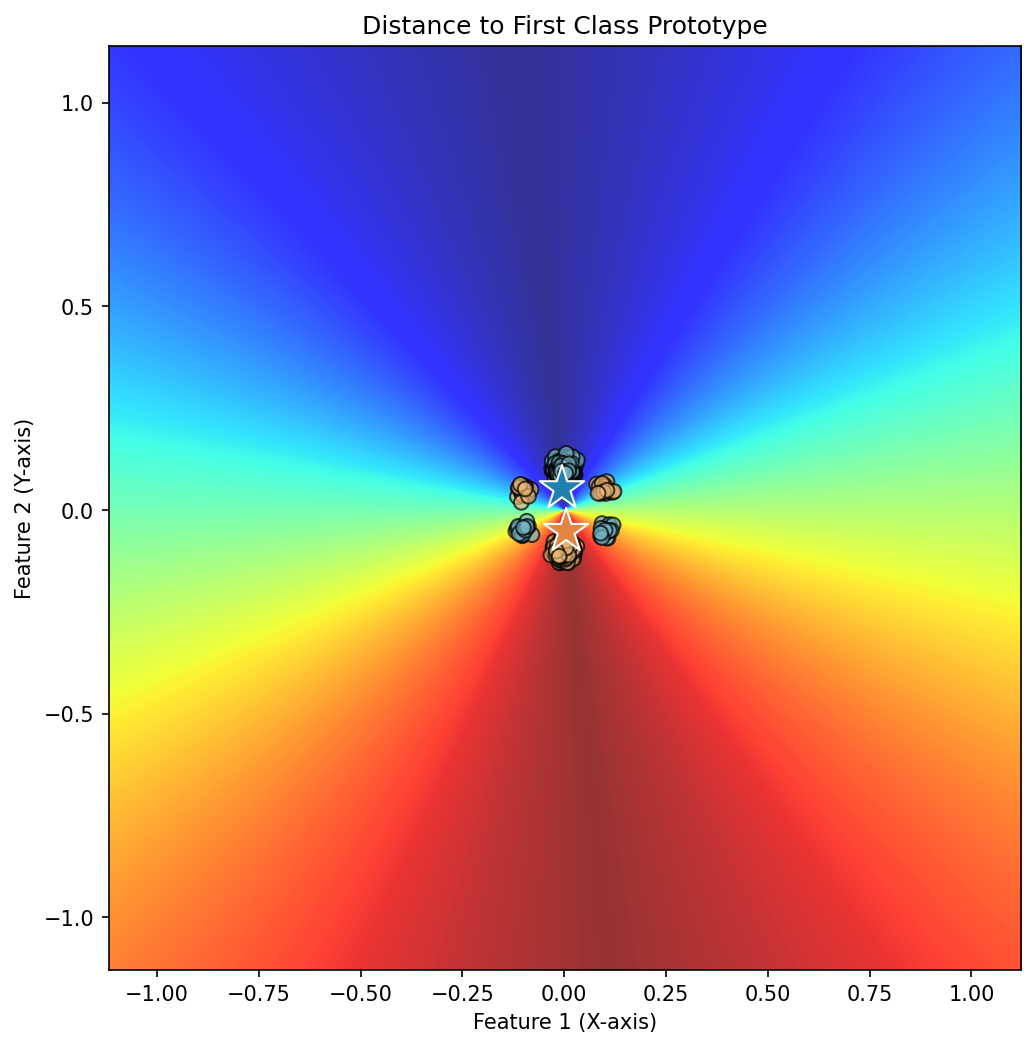

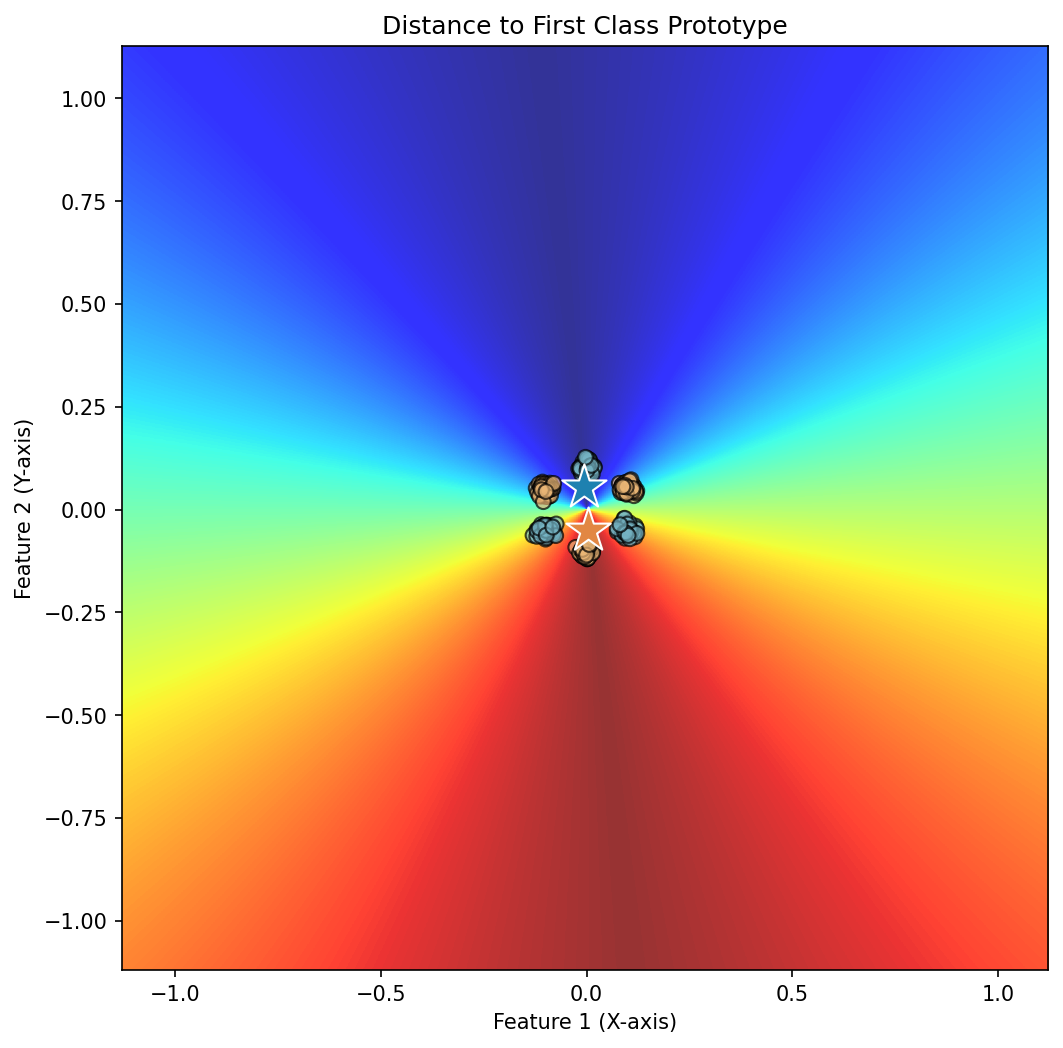

In [2]:
# Step 1: Generate Clusters
X_train, y_train, subgroups_train = generate_clusters(total_samples=2000, random_state=42)
X_test, y_test, subgroups_test = generate_balanced_clusters(total_samples=300, random_state=42)

# Step 4: Normalize Features
# X_train_normed, X_test_normed = normalize_features(X_train, X_test)
X_train_normed, X_test_normed = (X_train, X_test)

# Step 5: Create DataLoaders
training_loader, test_loader, train_size, test_size = create_dataloaders(X_train_normed, y_train, X_test_normed, y_test, batch_size=32)
_, training_eval_loader, *_ = create_dataloaders(X_train_normed, y_train, X_train_normed, y_train, batch_size=32)
print(f"Training samples: {train_size}, Testing samples: {test_size}")

# Step 6: Train the Model
input_dim = X_train_normed.shape[1]
num_classes = 2  # Binary classification
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = train_model(training_loader, test_loader, input_dim, num_classes, device=device, epochs=10, lr=1e-3, entropic_scale=1, optim_name='sgd')

# # -------------------------------
# # Execute the Function
# # -------------------------------
model.eval()
plot_distance_to_first_class(model, X_train_normed, y_train)
plot_distance_to_first_class(model, X_test_normed, y_test)

In [3]:
# Evaluate on Training Set
correct, true_pos = evaluate_model(model, training_eval_loader, device, set_name='Training')

subgroups_train_unique, counts = np.unique(subgroups_train, return_counts=True)
per_group_acc = [(sum(true_pos[subgroups_train==g])/count).item() for g, count in zip(subgroups_train_unique, counts)]
print(per_group_acc)

# Evaluate on Test Set
correct, true_pos = evaluate_model(model, test_loader, device)

subgroups_test_unique, counts = np.unique(subgroups_test, return_counts=True)
per_group_acc = [(sum(true_pos[subgroups_test==g])/count).item() for g, count in zip(subgroups_test_unique, counts)]
print(per_group_acc)

Training Accuracy: 96.00%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Test Accuracy: 33.33%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]


Training samples: 1920, Testing samples: 300


Epoch 5/5: 100%|██████████| 240/240 [00:00<00:00, 357.28it/s, acc=100.00%, loss=0.093]


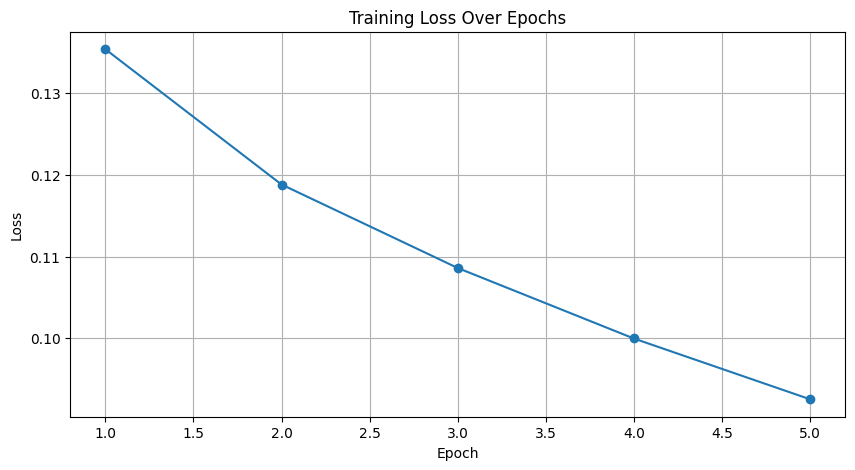

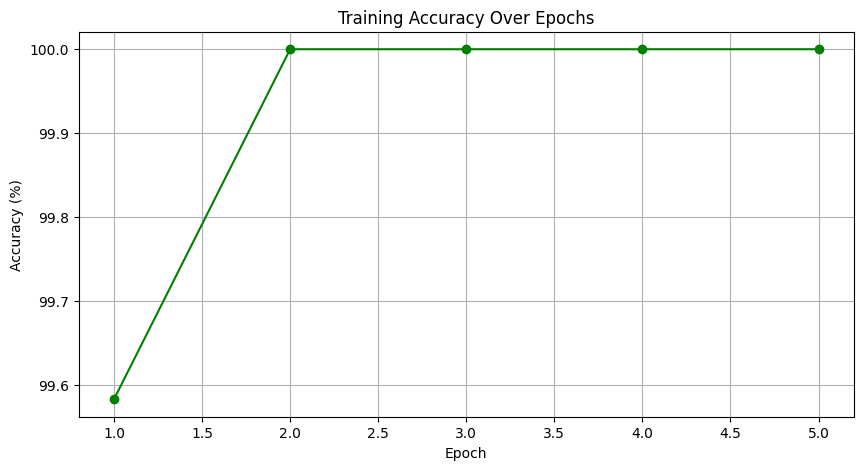

/tmp/ipykernel_29924/120160495.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(prototypes[:, 0], prototypes[:, 1], c=['#e28743', '#1e81b0'],


Test Accuracy: 33.33%
Training samples: 40, Testing samples: 300


Epoch 5/5: 100%|██████████| 5/5 [00:00<00:00, 402.49it/s, acc=100.00%, loss=0.135]


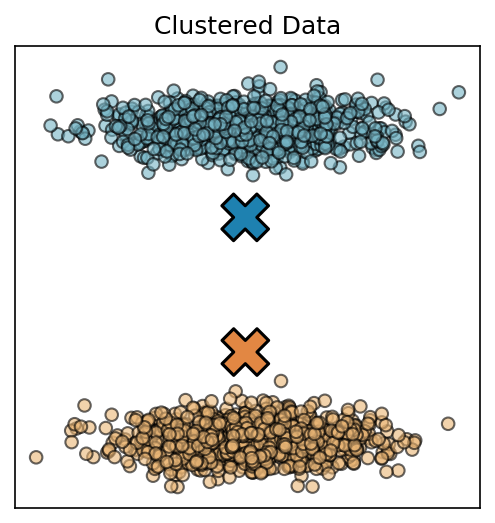

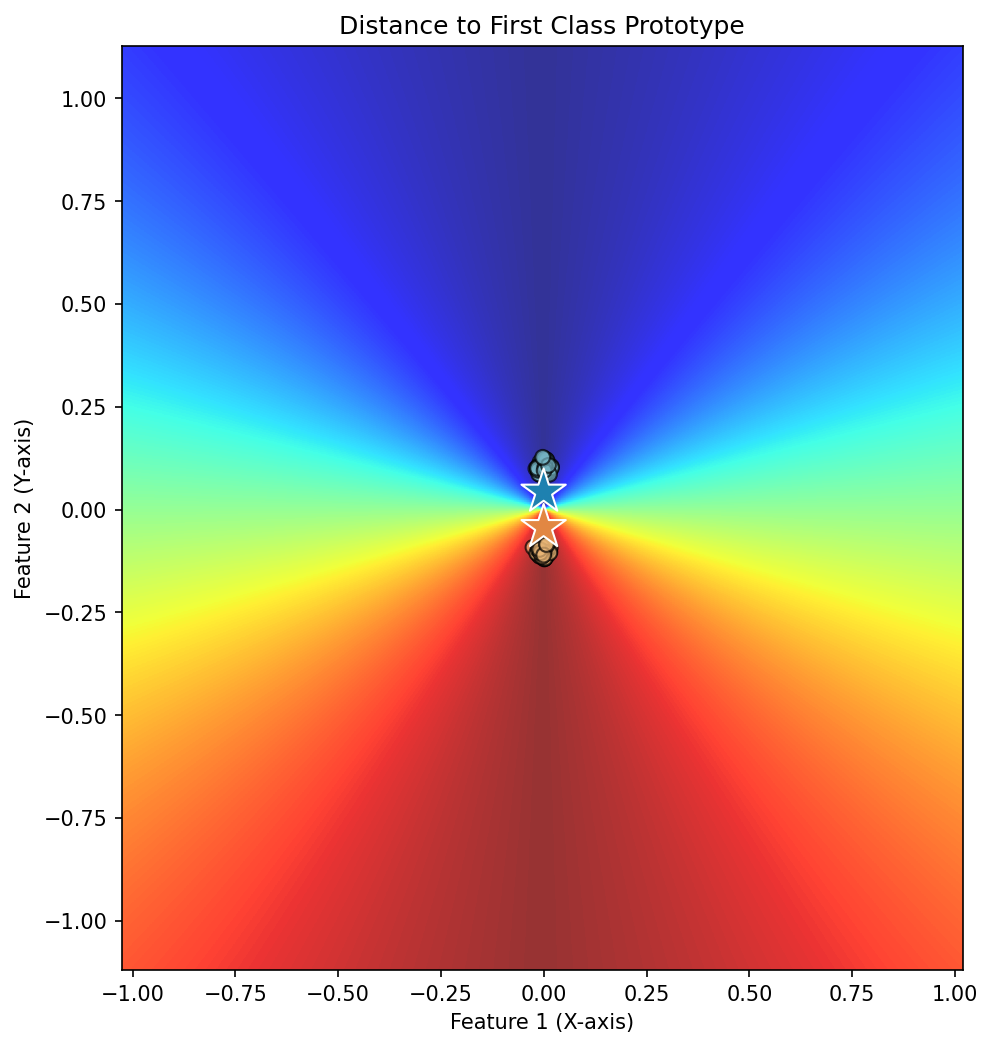

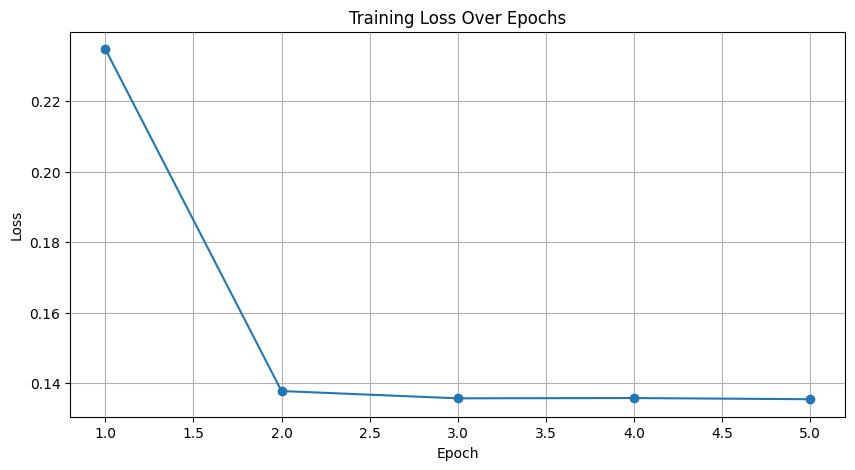

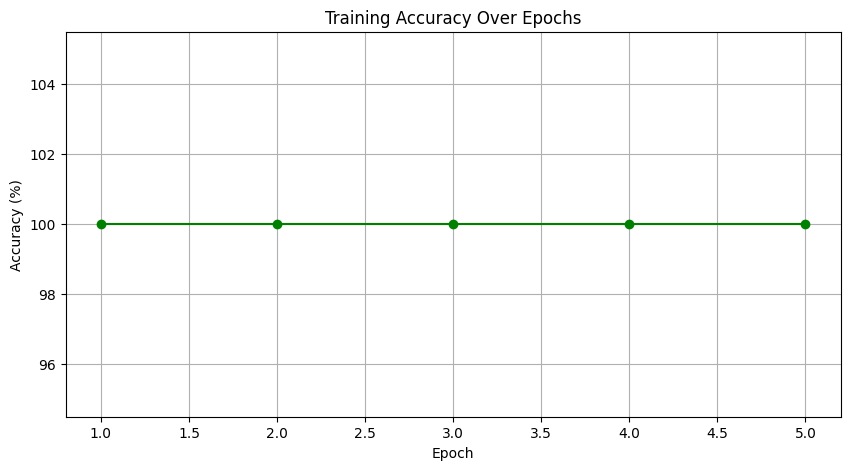

Test Accuracy: 33.33%
Training samples: 40, Testing samples: 300


Epoch 5/5: 100%|██████████| 5/5 [00:00<00:00, 401.55it/s, acc=100.00%, loss=0.137]


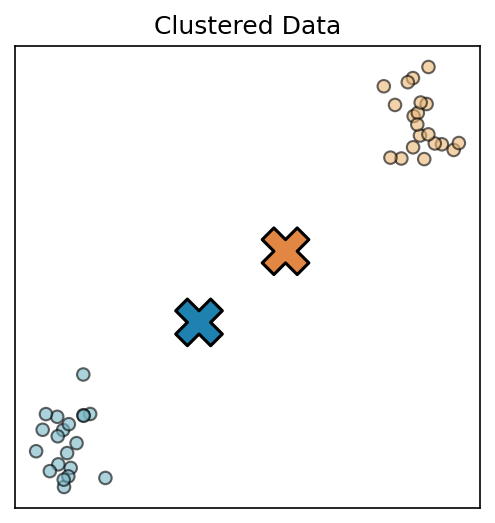

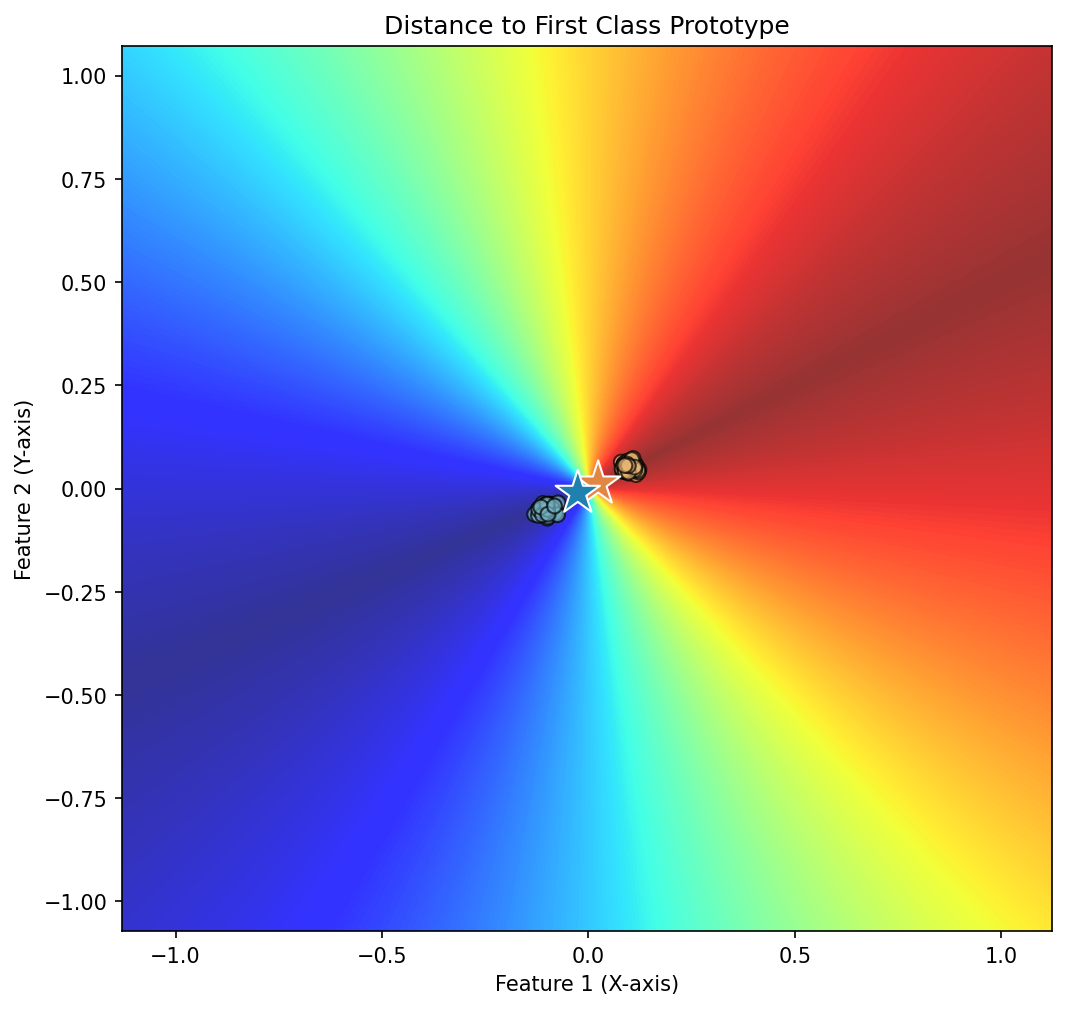

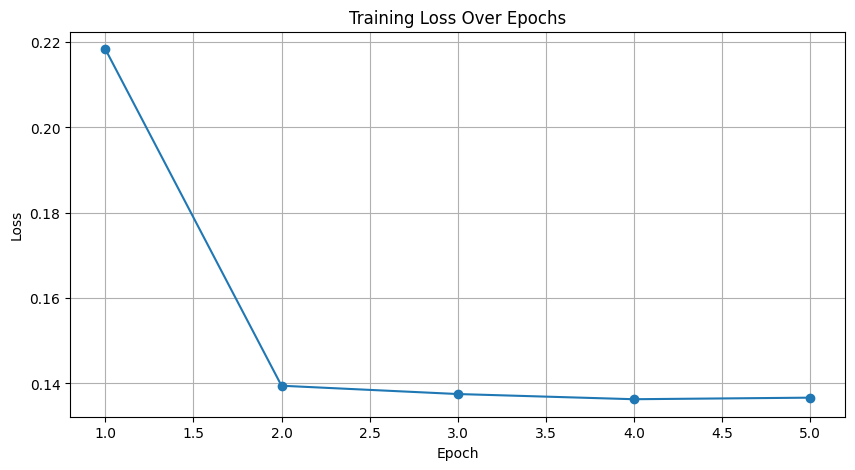

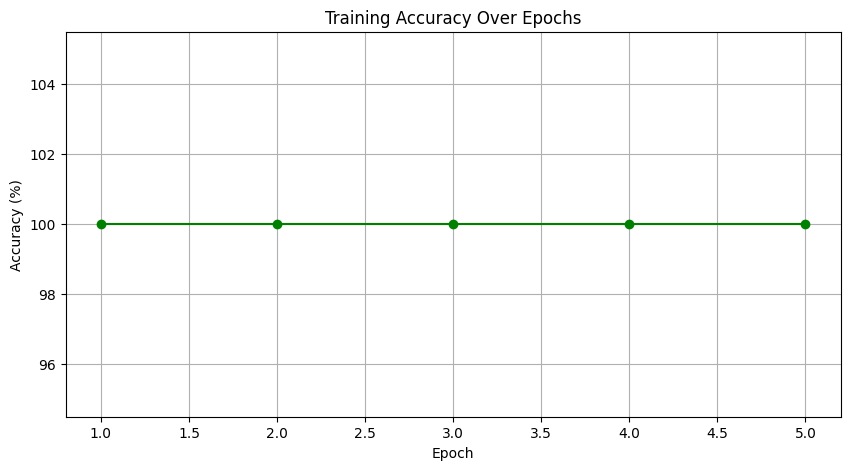

Test Accuracy: 33.33%
Training Accuracy: 96.00%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Test Accuracy: 33.33%
[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]

Training Accuracy: 2.00%
[0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
Test Accuracy: 33.33%
[0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

Training Accuracy: 2.00%
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Test Accuracy: 33.33%
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]



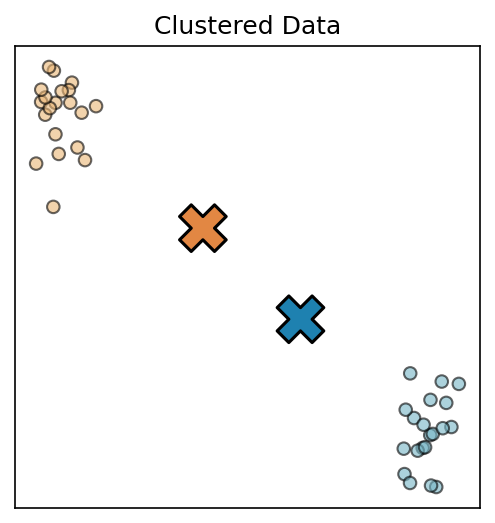

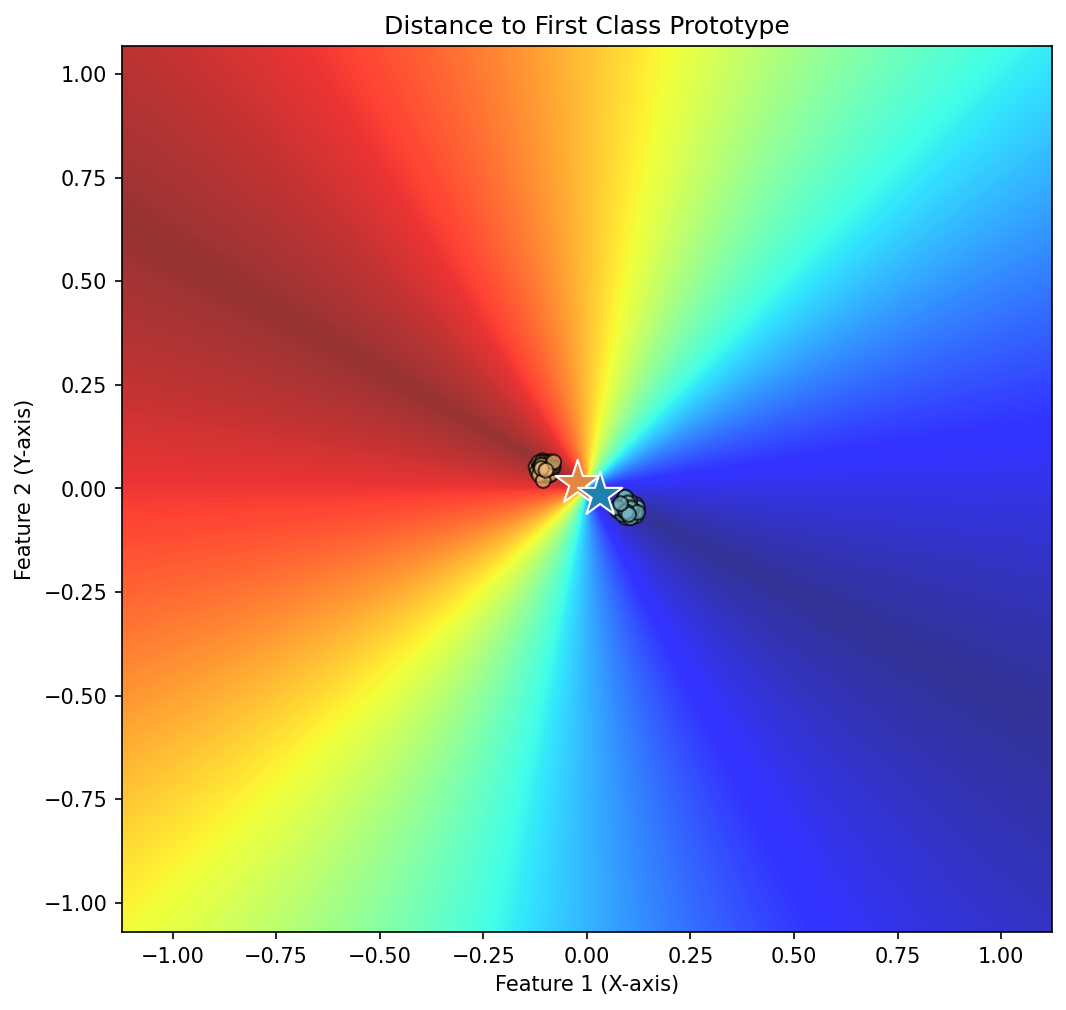

In [4]:
def train_subsampled(condition, condition_test=None):
    # Create DataLoaders on subgroup 2
    training_loader, test_loader, train_size, test_size = create_dataloaders(X_train_normed[condition], y_train[condition],
                                                                             X_test_normed, y_test, batch_size=8)
    _, training_eval_loader, *_ = create_dataloaders(X_train_normed, y_train, X_train_normed, y_train, batch_size=32)
    print(f"Training samples: {train_size}, Testing samples: {test_size}")

    # Train the Model
    input_dim = X_train_normed.shape[1]
    num_classes = 2  # Binary classification
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = train_model(training_loader, test_loader, input_dim, num_classes, device=device, epochs=5, lr=1e-3, optim_name='sgd',
                        entropic_scale=1)
    evaluate_model(model, test_loader, device)

    ax = plot_clusters(X_train_normed[condition], y_train[condition])
    prototypes = model.prototypes.detach().cpu().numpy()
    ax.scatter(prototypes[:, 0], prototypes[:, 1], c=['#e28743', '#1e81b0'],
               cmap='tab10', s=500, edgecolor='k', linewidths=1.5, marker='X')

    if condition_test is not None:
        model.eval()
        plot_distance_to_first_class(model, X_test_normed[condition_test], y_test[condition_test])
    return model


models = [
    train_subsampled(subgroups_train < 2, subgroups_test < 2),
    train_subsampled((subgroups_train > 1) & (subgroups_train < 4), (subgroups_test > 1) & (subgroups_test < 4)),
    train_subsampled(subgroups_train > 3, subgroups_test > 3)
]

# Evaluate on Training Set
for model in models:
    correct, true_pos = evaluate_model(model, training_eval_loader, device, set_name='Training')

    subgroups_train_unique, counts = np.unique(subgroups_train, return_counts=True)
    per_group_acc = [(sum(true_pos[subgroups_train == g]) / count).item() for g, count in
                     zip(subgroups_train_unique, counts)]
    print(per_group_acc)

    # Evaluate on Test Set
    correct, true_pos = evaluate_model(model, test_loader, device)

    subgroups_test_unique, counts = np.unique(subgroups_test, return_counts=True)
    per_group_acc = [(sum(true_pos[subgroups_test == g]) / count).item() for g, count in zip(subgroups_test_unique, counts)]
    print(per_group_acc)
    print()

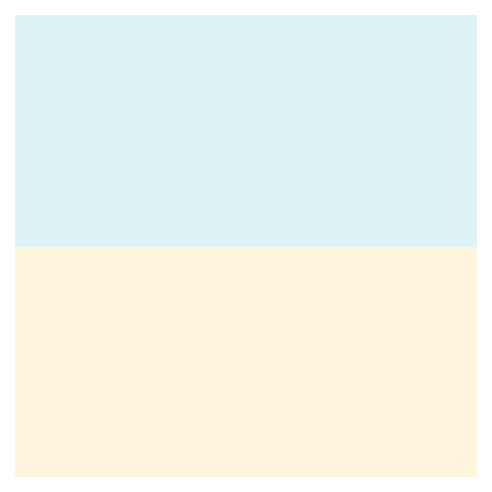

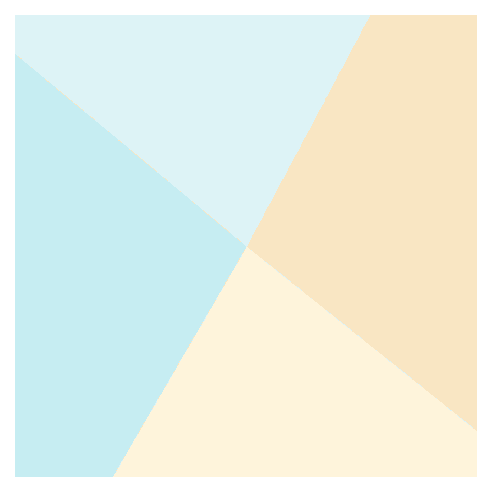

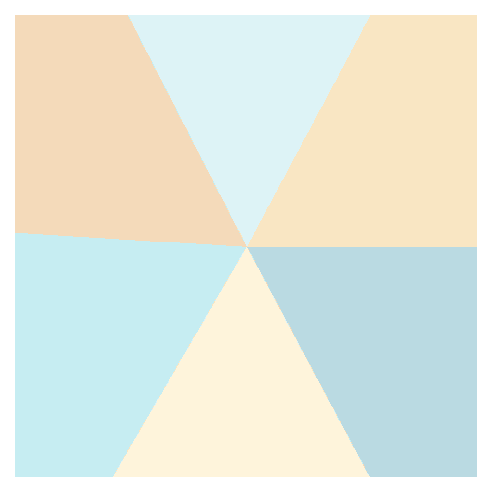

In [5]:
# -------------------------------
# Function to Generate Voronoi Diagram with Distance Coloring
# -------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch
import torch.nn as nn
import torch.nn.functional as F


def plot_distance_to_first_class_v1(prototypes, distance_scales, X, y, resolution=500):
    """
    Plots the data points with background color representing the distance to the first class's prototype.

    Parameters:
    - model: Trained IsoMaxPlusLossFirstPart model
    - X: Numpy array of shape (n_samples, 2), normalized training data
    - y: Numpy array of shape (n_samples,), class labels
    - resolution: Number of points along each axis for the mesh grid
    """
    # Extract prototypes from the model and convert to NumPy
    num_classes = 2

    if num_classes < 1:
        raise ValueError("Model must have at least one prototype.")

    # Define custom colors for classes
    custom_colors = ['#eab676', '#76b5c5', '#a1d99b', '#fdcdac', '#bae4b3', '#c6dbef']  # Extend as needed

    if num_classes > len(custom_colors):
        raise ValueError("Number of classes exceeds number of predefined colors.")

    # First class prototype
    proto = prototypes
    # proto = prototypes[1:2]
    # proto = prototypes[0:1]

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()].astype('float32')
    # grid_points = (grid_points - grid_points.mean(axis=0))/grid_points.std(axis=0)

    # Compute distances to the first class prototype
    distances = torch.abs(distance_scales) * torch.cdist(F.normalize(torch.tensor(grid_points)),
                                                        F.normalize(torch.tensor(proto)),
                                                        p=2.0, compute_mode="donot_use_mm_for_euclid_dist")
    distances = distances.argmin(axis=1)
    distances = distances.numpy().reshape(xx.shape)

    # Normalize distances for coloring
    norm = plt.Normalize(distances.min(), distances.max())
    cmap = plt.cm.jet  # Choose a suitable colormap

    fig = plt.figure(figsize=(4, 4), dpi=150)

    # Plot the distance-based coloring
    num_regions = len(np.unique(distances))
    colors = ['#fde9b7', '#bbe8ee', '#f4ce87', '#8edbe5', '#eab676', '#76b5c5']
    plt.imshow(
        distances,
        # extent=(x_min, x_max, y_min, y_max),
        origin='lower',
        # cmap=cmap,
        cmap=plt.matplotlib.colors.ListedColormap(colors[:num_regions]),
        norm=norm,
        alpha=0.5,
    )

    plt.grid(False)

    plt.xticks([])
    plt.yticks([])

    ax = plt.gca()

    # Optionally remove the spines for a cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)

prototypes = torch.concat([_.prototypes.detach().cpu() for _ in models]).numpy().astype('float32')
distance_scales = torch.concat([_.distance_scale.detach().cpu() for _ in models]).float()
distance_scales = distance_scales.repeat((2, 1)).T.flatten()
# plot_voronoi_with_distances(prototypes, distance_scales, X_test_normed, y_test)

plot_distance_to_first_class_v1(prototypes[:2], distance_scales[:2], X_test_normed, y_test)
plot_distance_to_first_class_v1(prototypes[:4], distance_scales[:4], X_test_normed, y_test)
plot_distance_to_first_class_v1(prototypes, distance_scales, X_test_normed, y_test)